In [1]:
import pandas as pd
import numpy  as np
from nilearn import image,plotting
from scipy import stats
import glob
import warnings
warnings.filterwarnings('ignore')
import matplotlib.image as mpimg
from matplotlib import pyplot as plt

In [3]:
import TransBrain as TB

## Optogenetic

### mouse opto phenotypes

In [4]:
AI_opto = pd.read_csv('AI_opto.csv')
DRN_opto = pd.read_csv('DRN_opto.csv')

In [5]:
AI_opto.set_index('Unnamed: 0',inplace=True,drop=True)
DRN_opto.set_index('Unnamed: 0',inplace=True,drop=True)

### translating mouse ai stimulated pattern to human

In [6]:
Transformer = TB.trans.SpeciesTrans()

INFO:root:SpeciesTrans initialized
INFO:root:Loading graph embeddings.


In [7]:
AI_trans_in_human = Transformer.mouse_to_human(AI_opto,region_type='all')

INFO:root:Mouse all phenotypes have been successfully transformed to human!


In [8]:
AI_trans_in_human.sort_values(by='AI_opto',ascending=False).head(30)

,AI_opto
rTtha,0.732512
mPFtha,0.568260
PPtha,0.469093
dIg,0.429137
vId/vIg,0.416277
G,0.389577
vIa,0.330202
Otha,0.286257
posterovemtral putamen,0.283502
dId,0.257844


In [9]:
Human_atlas = TB.atlas.fetch_human_atlas(region_type='all')

In [10]:
ai_z_score_map = np.zeros_like(Human_atlas['atlas_data'])

for i,row in Human_atlas['info_table'].iterrows():
    
    anatomical = row['Anatomical Name']
    atlas_index = row['Atlas Index']
    
    z_score = stats.zscore(AI_trans_in_human,axis=0)[AI_trans_in_human.index==anatomical].iloc[:,0].values[0]
    
    ai_z_score_map[Human_atlas['atlas_data']==atlas_index] = z_score

In [11]:
ai_z_score_map[ai_z_score_map<0] = 0

In [12]:
Synthetic_ai_stimulated_img = image.new_img_like(Human_atlas['atlas'],ai_z_score_map)

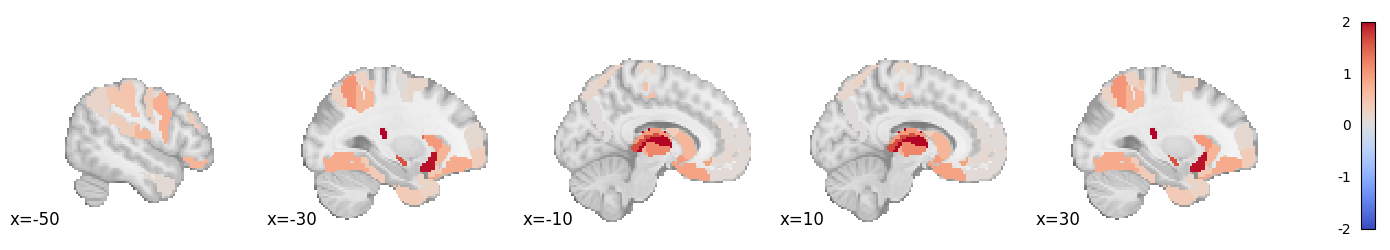

In [13]:
plotting.plot_stat_map(Synthetic_ai_stimulated_img ,draw_cross=False,display_mode='x',
                       annotate=True,cut_coords=range(-50,50,20),vmax=2,cmap='coolwarm',symmetric_cbar=True)

### translating mouse drn stimulated pattern to human

In [14]:
DRN_trans_in_human = Transformer.mouse_to_human(DRN_opto,region_type='all')

INFO:root:Mouse all phenotypes have been successfully transformed to human!


In [15]:
DRN_trans_in_human.sort_values(by='DRN_opto',ascending=False).head(30)

,DRN_opto
A24cd,1.003367
A23c,0.987585
A24rv,0.971778
A32p,0.906109
A31,0.903385
A32sg,0.825395
A23d,0.813636
A10m,0.804780
A8m,0.793313
A9m,0.774017


In [16]:
drn_z_score_map = np.zeros_like(Human_atlas['atlas_data'])

for i,row in Human_atlas['info_table'].iterrows():
    
    anatomical = row['Anatomical Name']
    atlas_index = row['Atlas Index']
    
    z_score = stats.zscore(DRN_trans_in_human,axis=0)[DRN_trans_in_human.index==anatomical].iloc[:,0].values[0]
    
    drn_z_score_map[Human_atlas['atlas_data']==atlas_index] = z_score

In [17]:
drn_z_score_map[drn_z_score_map<0] = 0

In [18]:
Synthetic_drn_stimulated_img = image.new_img_like(Human_atlas['atlas'],drn_z_score_map)

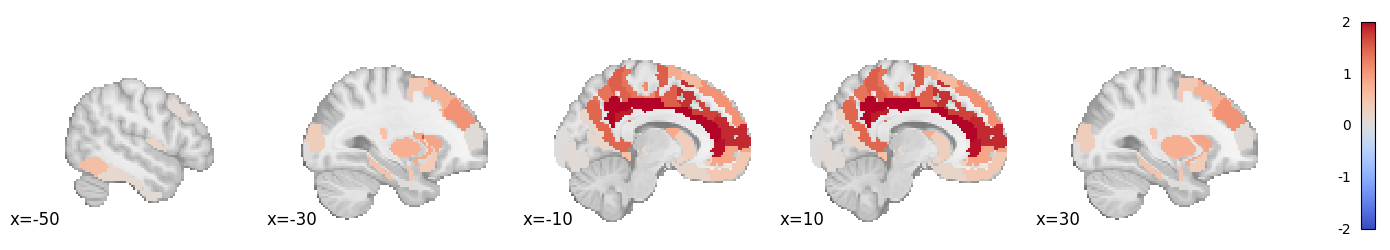

In [19]:
plotting.plot_stat_map(Synthetic_drn_stimulated_img ,draw_cross=False,display_mode='x',
                       annotate=True,cut_coords=range(-50,50,20),vmax=2,cmap='coolwarm',symmetric_cbar=True)

## annotating using NeuroSynth.

In [20]:
ai_thre = np.sort(stats.zscore(AI_trans_in_human['AI_opto'].values))[-20]
drn_thre = np.sort(stats.zscore(DRN_trans_in_human['DRN_opto'].values))[-20]

In [21]:
Synthetic_ai_img_data = np.asarray(Synthetic_ai_stimulated_img.dataobj)
Synthetic_drn_img_data = np.asarray(Synthetic_drn_stimulated_img.dataobj)

In [22]:
Synthetic_ai_img_data[Synthetic_ai_img_data<ai_thre] = 0
Synthetic_drn_img_data[Synthetic_drn_img_data<drn_thre] = 0

In [23]:
ai_dict_top_term = {}
for path in glob.glob('./neurosynth_data/*.nii.gz'):
    
    term_  =  path.split('/')[-1].split('_')[0]
    
    target_z_map_data = np.asarray(image.load_img(path).dataobj)
    target_z_map_data[target_z_map_data<0]=0
    
    stat_zero_data = np.zeros_like(target_z_map_data)
    stat_zero_data[(target_z_map_data!=0)&(Synthetic_ai_img_data!=0)] = 1
    
    try:
        overlap_rate = len(stat_zero_data.flatten()[stat_zero_data.flatten()!=0])/len(target_z_map_data.flatten()[target_z_map_data.flatten()!=0])
        ai_dict_top_term[term_] = overlap_rate
    except:
        print(term_)

In [24]:
ai_top_term_dataframe = pd.DataFrame(ai_dict_top_term.values())
ai_top_term_dataframe.index = ai_dict_top_term.keys()

In [25]:
ai_top_term_dataframe.sort_values(by=0,ascending=False).head(20)

,0
addiction,0.328380
decision making,0.276786
decision,0.266892
eating,0.264292
risk,0.244253
anticipation,0.223714
loss,0.218065
reinforcement learning,0.216023
selective attention,0.207113
pain,0.201087


In [26]:
drn_dict_top_term = {}
for path in glob.glob('./neurosynth_data/*.nii.gz'):
    
    term_  =  path.split('/')[-1].split('_')[0]
    
    target_z_map_data = np.asarray(image.load_img(path).dataobj)
    target_z_map_data[target_z_map_data<0]=0
    
    stat_zero_data = np.zeros_like(target_z_map_data)
    stat_zero_data[(target_z_map_data!=0)&(Synthetic_drn_img_data!=0)] = 1
    
    try:
        overlap_rate = len(stat_zero_data.flatten()[stat_zero_data.flatten()!=0])/len(target_z_map_data.flatten()[target_z_map_data.flatten()!=0])
        drn_dict_top_term[term_] = overlap_rate
    except:
        print(term_)

In [27]:
drn_top_term_dataframe = pd.DataFrame(drn_dict_top_term.values())
drn_top_term_dataframe.index = drn_dict_top_term.keys()

In [28]:
drn_top_term_dataframe.sort_values(by=0,ascending=False).head(20)

,0
monitoring,0.443730
uncertainty,0.362245
response selection,0.340757
inference,0.318267
efficiency,0.264368
reasoning,0.254344
memory retrieval,0.253528
social cognition,0.230468
thought,0.230189
inhibition,0.224599


In [29]:
AI_trans_in_human_sorted = stats.zscore(AI_trans_in_human).sort_values(by='AI_opto',ascending=False)
DRN_trans_in_human_sorted = stats.zscore(DRN_trans_in_human).sort_values(by='DRN_opto',ascending=False)

In [30]:
categories = list(AI_trans_in_human_sorted[AI_trans_in_human_sorted['AI_opto']>=ai_thre].index.values)
values = list(stats.zscore(AI_trans_in_human_sorted)[AI_trans_in_human_sorted['AI_opto']>=ai_thre]['AI_opto'].values)

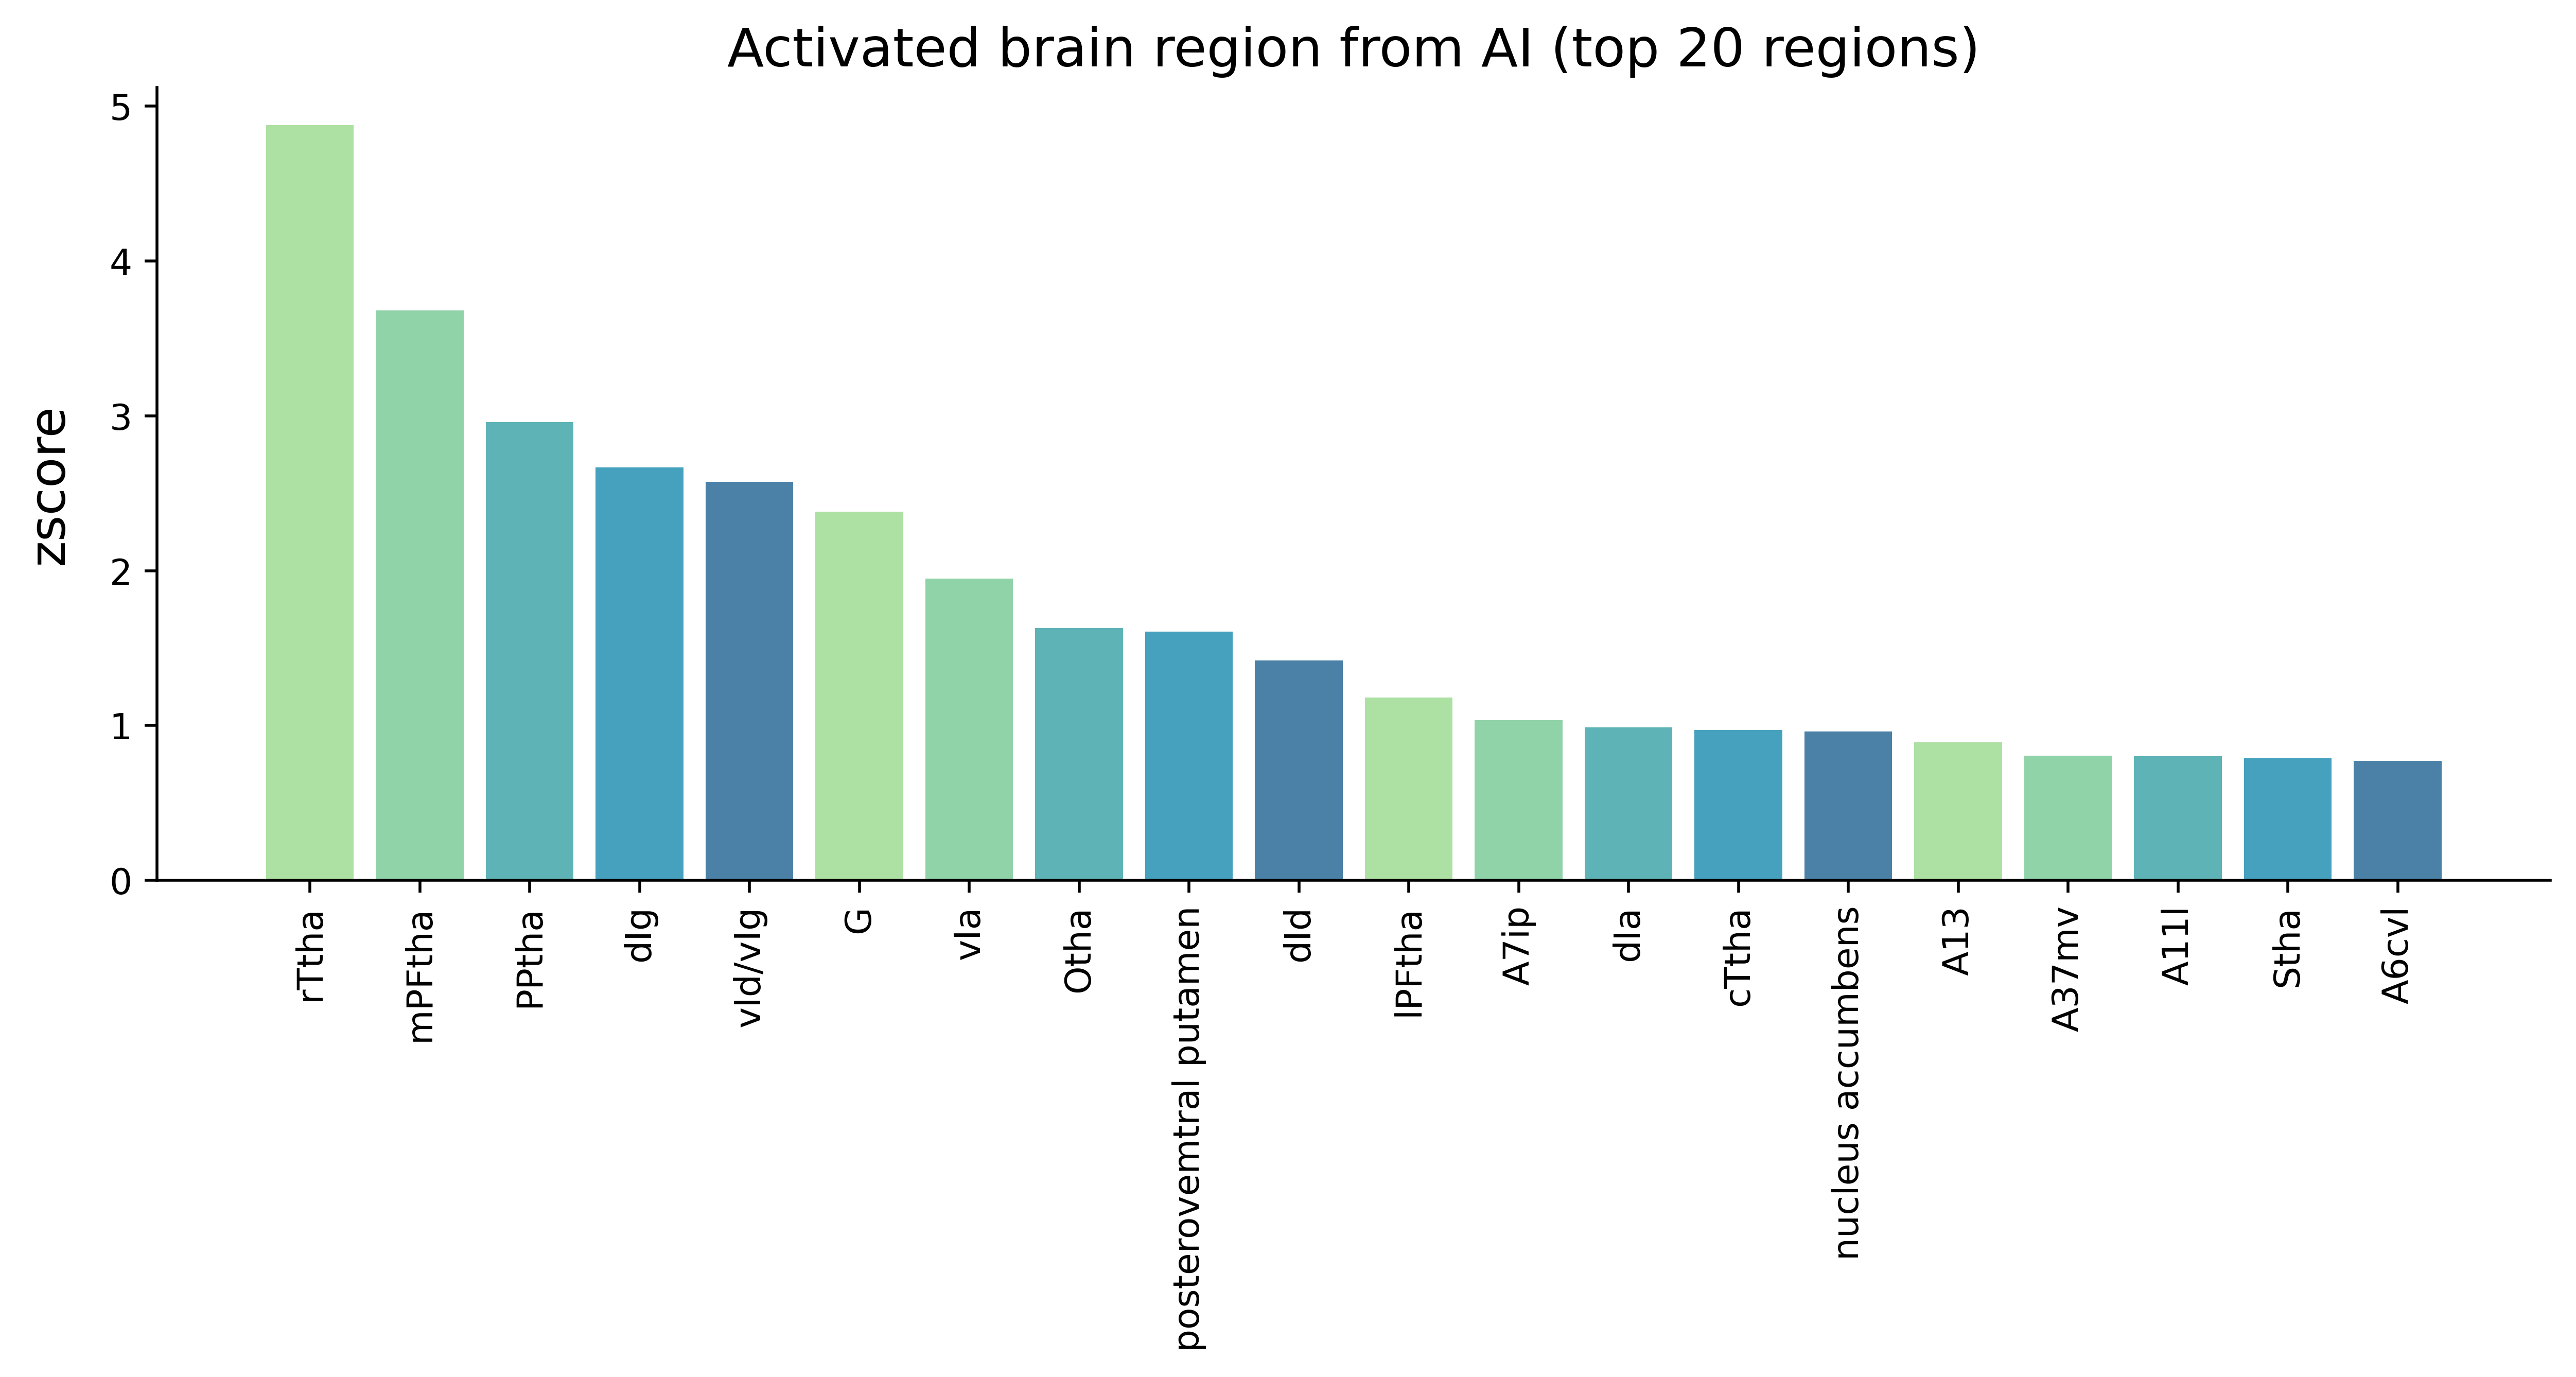

In [31]:
colors = ['#99d98c', '#76c893', '#34a0a4', '#168aad', '#1e6091']
fig,ax = plt.subplots(1,1,figsize=(12,4),dpi=500)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.bar(categories, values, color=colors,alpha=0.8)
plt.title('Activated brain region from AI (top 20 regions)',fontsize=15)
plt.ylabel('zscore',labelpad=10,fontsize=14)
plt.xticks(categories, rotation='vertical')
plt.show()

In [32]:
categories = list(DRN_trans_in_human_sorted[DRN_trans_in_human_sorted['DRN_opto']>=drn_thre].index.values)
values = list(stats.zscore(DRN_trans_in_human_sorted)[DRN_trans_in_human_sorted['DRN_opto']>=drn_thre]['DRN_opto'].values)

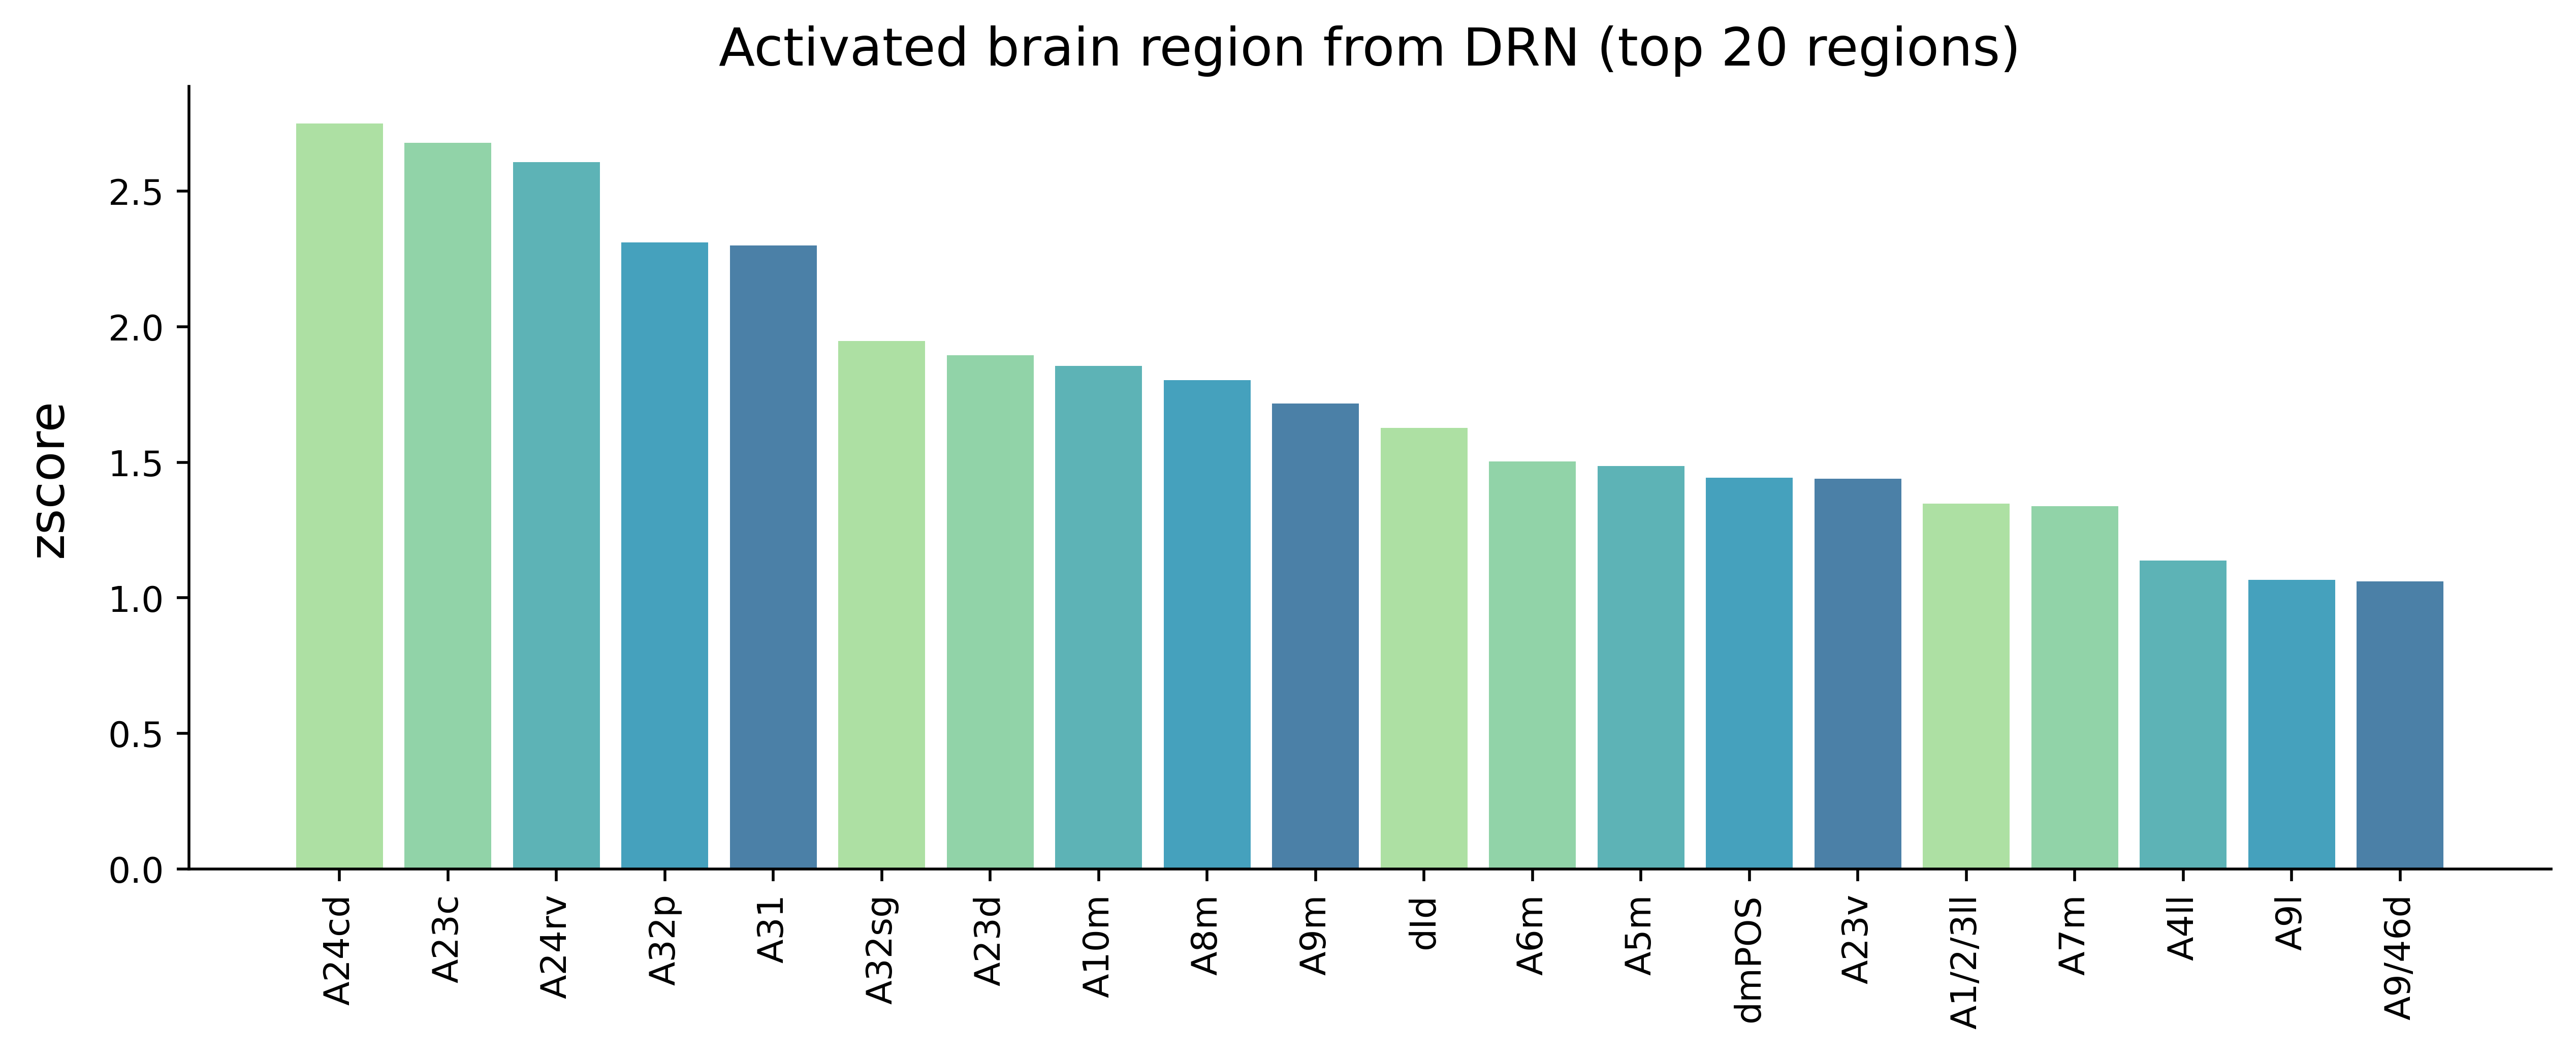

In [33]:
colors = ['#99d98c', '#76c893', '#34a0a4', '#168aad', '#1e6091']
fig,ax = plt.subplots(1,1,figsize=(12,4),dpi=500)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.bar(categories, values, color=colors,alpha=0.8)
plt.title('Activated brain region from DRN (top 20 regions)',fontsize=15)
plt.ylabel('zscore',labelpad=10,fontsize=14)
plt.xticks(categories, rotation='vertical')
plt.show()